# Preparation
The pre-requisites for the command server to work properly is that there must be a motion_server.py running, REEM state server (state_server.py), and Command Server (command_server.py)

Open 3 console windows, and run

```
cd ~/TRINA/Motion; python3 motion_server.py
```

in one window,

```
cd ~/TRINA; python3 trina/state_server.py
```

in another, and 

```
cd ~/TRINA; python3 trina/command_server.py
```
in a third.

(an alternative is to use the redrun script `redrun redrun_config.json`, but doing this manually will help you understand the different pieces going on.)


# Imports
Import both Jarvis and command_server (you won't need to import command server usually, as it should be always be running on TRINA_GPU, but if you're doing a local test, it has to be imported and instantiated)

In [1]:
#set up the system path so it contains ~/TRINA
import sys
import os
import time
sys.path.append(os.path.expanduser("~/TRINA"))

In [2]:
import trina
from trina import jarvis

# Instantiate Jarvis and command server

Same thing here, on real trina, you only need to import jarvis, as the command_server would always be running

In [ ]:
# command_server = CommandServer()

#if you create your own Jarvis instance, then it will only have basic hooks to the robot and ui apis.
#- robot is a MotionAPI instance (see trina/modules/Motion/api.py)
#- ui is a UIAPI instance (see trina/modules/UI/api.py)
jv = jarvis.Jarvis('testing')

#By default, Command Server will be checking the health of modules
jv.enableHealthChecks(False)

In [ ]:
print(jv.server['ACTIVITY_STATUS'].read())
print(jv.server['HEALTH_LOG'].read())


In [ ]:
jv.robot.sensedRobotq()

In [ ]:

# # for i in a.keys():
# #     k = jv.server['ACTIVITY_STATUS'][i]
print(jv.server['ROBOT_INFO'].read())
# test.changeActivityStatus([str('C2')])
print(jv.server['UI_STATE'].read())

# print(jv.server['ROBOT_COMMAND'].read())
# time.sleep(0.01)



## Motion commands

If you'd like to see the robot move, run in a new command line window

```
cd ~/TRINA; python3 Debugging/state_visualizer.py
```

And then run the below code

In [ ]:

#move forward a little
for i in range(10):
    jv.robot.setBaseVelocity([(5-abs(4-i))*0.1,1])
    time.sleep(0.2)

for i in range(10):
    jv.robot.setBaseVelocity([-(5-abs(4-i))*0.1,1])
    time.sleep(0.2)

jv.robot.setBaseVelocity([0,0])
#     j3.setBaseVelocity([0,1])


# Getting more from Jarvis in scripts / IPython

Modules can get much more from Jarvis, such as using shared memory objects from various Jarvis APIs, e.g., the Sensor module. 

The tricky part, however, is that you will have to run the CommandServer object in your own code, rather than the command line. **Make sure to terminate the existing process running command_server.py before you run the code below**.

Then, make a dummy module to get a properly initialized Jarvis instance.  CommandServer will automatically spawn several threads to serve requests across the system.  In Jupyter, these threads will be run automatically in the background so you can interact with the Jarvis instance.

In [3]:
if 'server' in globals():
    server.shutdown_all()
from trina.command_server import CommandServer
server = CommandServer(['Motion','Sensor','Example'])
jv2 = server.start_dummy_module('testing2')



 Starting New Modules:['Motion', 'Sensor', 'Example']



  Starting module Motion ...







 Initializing robot states



  Starting module Sensor ...




SensorModule: ROS support requested, but rospy could not be imported




Updating simulated camera realsense_right to match calibration in TRINA/Settings/
Updating simulated camera realsense_left to match calibration in TRINA/Settings/



  Starting module Example ...



(localhost,) {}


## Example module
We can start seeing how to interact with APIs using the Example module.

In [ ]:
print([fn for fn in dir(jv2.example) if not fn.startswith('_')])

In [ ]:
result = jv2.example.add(3,5)
print(result)  #we get a Promise object
print(result.await())  #this waits until the Promise results are available

Another way to get RPC results is through polling.  How quickly the result gets here depends on how quickly the Example module polls the State Server.

In [ ]:
result = jv2.example.sin([0.1,0.2,0.3,0.4,0.5])
while not result:
    print("Polling...")
    time.sleep(0.01)
print("Result",result.value())

## Sensor module

When the Sensor module is run (in kinematic mode), `jarvis.sensor` contains a SensorAPI object.  See `trina/modules/Sensors/api.py` for detailed documentation.

In [ ]:
print([fn for fn in dir(jv2.sensors) if not fn.startswith('_')])

In [4]:
images = jv2.sensors.getNextRgbdImages().await()

In [5]:
print(images.keys())

dict_keys(['l515_torso', 'zed_head', 'realsense_left', 'realsense_right'])


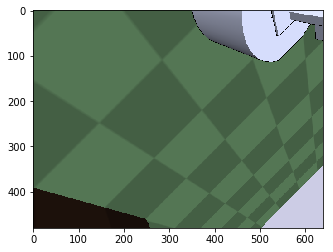

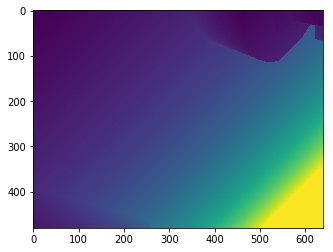

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
#here are the color and depth images
plt.imshow(images['realsense_right'][0])
plt.show()
plt.imshow(images['realsense_right'][1])
plt.show()

In [ ]:
scan = jv2.sensors.getLidarScan()
plt.plot(scan)
plt.show()

In [7]:
lidar_pc = jv2.sensors.getLidarPointCloud()

Angle range -1.91986 1.91986
Disance range 1.28 25.0


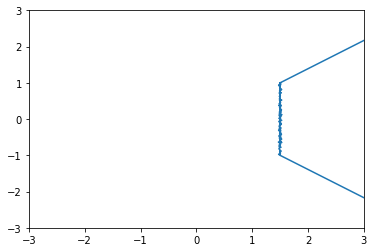

In [10]:
plt.plot(lidar_pc[:,0],lidar_pc[:,1])
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

## Extra debugging

If things aren't going well, perhaps you should check out the redis server using `redis-cli` or some other redis server snooping tool